# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [2]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from scipy import linalg

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

        PCA will attempt to combine some of the features to create composite features with minimal information loss, so the first components will account for the highest proportion of variation in the data. Remembering that standard deviation is the square root of the variance, and given that the descriptive statistics table in the summary of the project shows that the biggest standard deviation (12k) is on the “Fresh” attribute, I expect the first component to reflect that. Using the same logic, I believe the following components will represent “Grocery” (9K) and “Milk” (7K),  and the following components will correspond to the rest of the attributes who have smaller standard deviations.

        ICA on the other hand will find dimensions that are independent from each other (not correlated). In other words, It will pick out features that are significant on their own. 

### PCA

In [3]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print 'Components:'
print ''
df = pd.DataFrame(pca.components_, columns=list(data.columns))
print df

print ''
print 'Explained Variance by Component:'
print pca.explained_variance_ratio_ , ' - Total:', sum( pca.explained_variance_ratio_)

Components:

      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicatessen
0 -0.976537 -0.121184 -0.061540 -0.152365          0.007054     -0.068105
1 -0.110614  0.515802  0.764606 -0.018723          0.365351      0.057079
2 -0.178557  0.509887 -0.275781  0.714200         -0.204410      0.283217
3 -0.041876 -0.645640  0.375460  0.646292          0.149380     -0.020396
4  0.015986  0.203236 -0.160292  0.220186          0.207930     -0.917077
5 -0.015763  0.033492  0.410939 -0.013289         -0.871284     -0.265417

Explained Variance by Component:
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]  - Total: 1.0


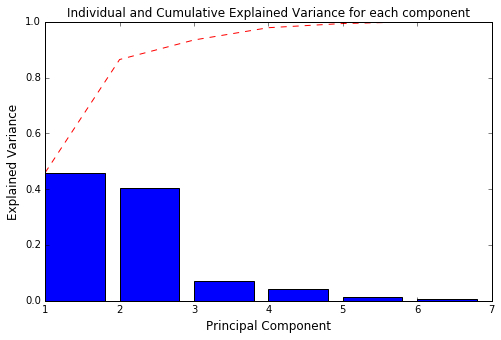

In [4]:
n = data.shape[1]

plt.figure(figsize=(8,5))
plt.bar(xrange(1,n+1), pca.explained_variance_ratio_)
plt.plot(np.arange(1,7), np.cumsum(pca.explained_variance_ratio_),'r--')
plt.ylim(ymax = 1, ymin = 0)
plt.xlabel('Principal Component', size=12)
plt.ylabel('Explained Variance', size=12)
plt.title('Individual and Cumulative Explained Variance for each component')

**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

        The variance explanation drops very quickly in this dataset. Python’s PCA implementation orders the components in terms of explained variance, meaning that the first component explains more variance and the last component explains less variance.
        In this example, the first component explains 46% of variance and the second, explains 40%. The next 4 components together explain only 14%.
        From looking at the graph and analysing the numbers, we can conclude that the first two principal components retains majority of the variance, so I’d choose only 2 components in this case.

**3)** What do the dimensions seem to represent? How can you use this information?

        The overall length of the principal component vector is 1 (the sum of each weight squared), so if we observe a coefficient that has a large magnitude, then we know that most of the weight of that principal component is on that single feature and the rest of the weights will be relatively small. We also tend to see that correlated features have smaller coefficient values, due to the need to “share” weight on each of the features.

        So looking at the first Principal Component, we can see that it mainly focus on  the “Fresh” attribute, as the second PC corresponds focus on “Grocery” and “Milk” and some of ”Detergents_Paper”.  Because the first two components  account for most of the explained variance ratio, it means there's a lot of variance in them. That can be confirmed by looking at each columns’ standard deviation (which is the square root of variance) and verifying that “Fresh” and “Grocery” have the higher (12647 and 9503 respectively, while the less variant, Delicatessen, is 2820)

        Technically speaking, this means that  the first two components explain the majority of the variance on the data (thus the most information) so, instead of representing our data in 6 dimensions, we can represent it only in two dimensions without much information loss.

        From a business point of view, the first PC tells us that there is a lot of variation on the purchase of “fresh” products from shop to shop. We could use this information to focus the shops that buy less “fresh” products and try to make them buy more products of that kind. The Second PC, tells us that stores that buy more 'grocery' items tend also to buy more 'milk' items and to some degree more 'detergents_paper' items as well (“more” because they all have the positive sign).  This is very interesting because we could increase the sales even more by trying to fit a promotion across those 3 classes of products.

        The code and image bellow shows the 2 dimensinal representaion of PC1 and PC2 with the original feature projections. It needs the seaborn package installed.

PC 1 : -0.976536845622 -0.110613856391
PC 2 : -0.121184070841 0.515802158666
PC 3 : -0.0615403930688 0.764606384951
PC 4 : -0.152364619302 -0.018723454585
PC 5 : 0.0070541734646 0.365350762487
PC 6 : -0.0681047102627 0.0570792132091


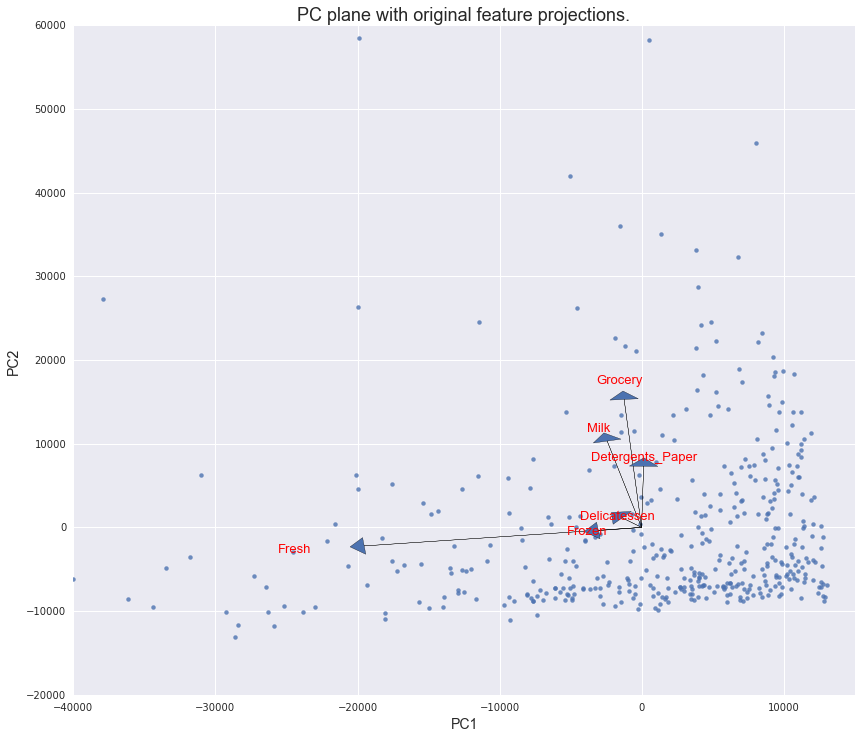

In [5]:
try:
    import seaborn as sns
    plt.figure(figsize=(14, 12))
    plt.ylim(ymax = 60000, ymin = -20000)
    plt.xlim(xmax = 15000, xmin = -40000)
    transformed = pca.fit_transform(data)
    sns.regplot(transformed[:, 0], transformed[:, 1], fit_reg=False)
    feature_vectors = pca.components_.T
    feature_vectors =  feature_vectors
    arrow_size = 2e4
    text_posX = 2.5e4
    text_posY = 2.3e4
    for i, v in enumerate(feature_vectors):
        print 'PC',i+1,':', v[0], v[1]
        plt.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=2000, head_length=1000)    
        plt.text(v[0]*text_posX, v[1]*text_posY, df.columns[i], color='r', ha='center', va='center', fontsize=13)
    plt.xlabel("PC1", fontsize=14)
    plt.ylabel("PC2", fontsize=14)
    plt.title("PC plane with original feature projections.", fontsize=18)
    plt.show()
except ImportError, e:
    print 'Module seaborn doesn''t exist. Install it to view the image.'

### ICA

In [6]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from sklearn.decomposition import FastICA
from sklearn import preprocessing

ica = FastICA(random_state = 123)
# Note: Adjust the data to have center at the origin first!
scaled_data = preprocessing.scale(data)
ica.fit(scaled_data)

# Print the independent components
print 'Components:'
print ''
df = pd.DataFrame(ica.components_*100, columns=list(data.columns))
print df

Components:

   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0   1.09  0.11    -0.74   -5.41              0.26          1.68
1  -0.25  1.27    -7.10   -0.13              1.56          0.55
2   0.33 -1.93   -10.77    0.73             13.31          1.61
3   0.21  7.22    -5.67   -0.16              1.80         -1.68
4   5.03 -0.66    -0.75   -0.32              1.16         -0.27
5  -0.49 -0.16    -0.56   -0.25              0.24          5.09


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

        Within each component, the magnitude of each feature’s coefficient indicates how important it is inside that component vector. Two coefficients with the same sign indicate correlation between them. If they have opposite sign, it implies that customers who buy more from one group buy less from the other.
        This information can be used by the marketing department to increase sales by offering discount or promotions on products that relate to one another for example:
        
        •	IC1: Indicates purchase of “Frozen” products;
        •	IC2: Indicates purchase of “Grocery” products;
        •	IC3: Indicates purchase of “Grocery” and “Detergent_papers” products, and that they are negatively correlated;
        •	IC4: Indicates the same relationship between “Milk” and “Grocery” as above, but not as strong because the coeficinets are smaller;
        •	IC5: Indicates purchase of “Fresh” products;
        •	IC5: Indicates purchase of “Delicatessen” products;


        Bellow is a grphical representation of the independent components:

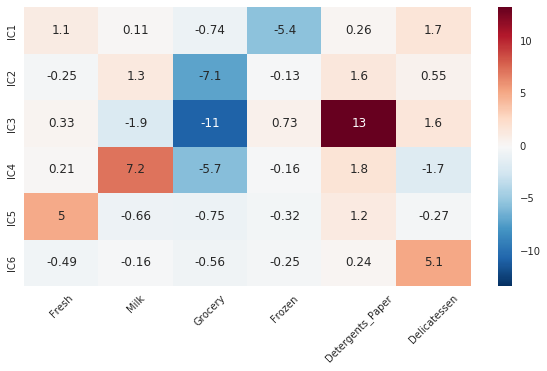

In [7]:
try:
    import seaborn as sns
    idx=[]
    for i in range(1,7):
        idx.append('IC'+str(i))
    idx

    ica_plot = pd.DataFrame(ica.components_*100, columns=list(data.columns), index = idx)

    plt.figure(figsize=(10,5))
    plt.xticks(rotation=45)
    sns.heatmap(ica_plot, annot=True)
except ImportError, e:
    print 'Module seaborn doesn''t exist. Install it to view the image.'    

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

    K Means clustering:

    •	Tries to place centroids that are most equidistant to other points in the same cluster;
    •	Clusters are usually defined by strait lines;
    •	Less Expensive and faster than GMM;
    


    Gaussian Mixture Models:

    •	Is a parametric probability density model representing a weighted sum of Gaussian densities;
    •	Calculates the probability that a particular point belong to the cluster;
    •	Clusters are usually defined as ellipsis;
    •	It does soft assignment to maximize the probability that the data points belong to one cluster or another;
    •	Can be more expensive and slower than KMeans;
    •	Gives more information on the probability of the data clusters;
    

        I will use (plot) both algorithms – mainly to compare them - but will base my analysis on GMM simply because it assumes less from the data and gives better clusters (it uses ellipses along the x axis and y axis which is more intuitive) and in such small dataset, its drawbacks related to performance are not really applicable. 

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [8]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

# TODO: First we reduce the data to two dimensions using PCA to capture variation
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)
print reduced_data[:10]  # print upto 10 elements

[[  -650.02212207   1585.51909007]
 [  4426.80497937   4042.45150884]
 [  4841.9987068    2578.762176  ]
 [  -990.34643689  -6279.80599663]
 [-10657.99873116  -2159.72581518]
 [  2765.96159271   -959.87072713]
 [   715.55089221  -2013.00226567]
 [  4474.58366697   1429.49697204]
 [  6712.09539718  -2205.90915598]
 [  4823.63435407  13480.55920489]]


In [51]:
def get_clusters(model, n_clusters, covariance_type):
    if model=='KMeans':
        clusters = KMeans(n_clusters=n_clusters)
    else:
        clusters = GMM(n_components=n_clusters, covariance_type = covariance_type, random_state = 9999)

    clusters.fit(reduced_data)

    # Plot the decision boundary by building a mesh grid to populate a graph.
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    hx = (x_max-x_min)/1000.
    hy = (y_max-y_min)/1000.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])    
    
    if model=='KMeans':    
        centroids = clusters.cluster_centers_ 
    else:        
        centroids = clusters.means_
        model = 'GMM'
    
    #print centroids
    
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(12,8))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,               
               aspect='auto', origin='lower')
    

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=4)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=169, linewidths=3,color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross\n' + model +' model - '+ str(n_clusters) +' clusters')
    
    #plt.xlim(x_min, x_max)
    #plt.ylim(y_min, y_max)
    
    #manually setting the axis limits to help improve vizualization:
    plt.xlim(-70000, 13025)
    plt.ylim(-14000, 80000)
    
    plt.xticks(())
    plt.yticks(())
    
        
    feature_vectors = pca.components_.T
    feature_vectors =  feature_vectors#[0:2]
    arrow_size, text_pos = 5e4, 5.5e4
    for i, v in enumerate(feature_vectors):        
        plt.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=2000, head_length=1000)    
        plt.text(v[0]*text_pos, v[1]*text_pos, df.columns[i], color='w', ha='center', va='center', fontsize=12, fontweight='bold')
    plt.xlabel("PC1", fontsize=14)
    plt.ylabel("PC2", fontsize=14)
    
    plt.show()
    return centroids

In [52]:
#http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html
def get_bestModelByBIC():
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 8)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:    
        for n_components in n_components_range:
            # Fit a mixture of Gaussians with EM
            gmm = GMM(n_components=n_components, covariance_type=cv_type, random_state = 9999)
            gmm.fit(reduced_data)
            bic.append(gmm.bic(reduced_data))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm


    bic = np.array(bic)
    color_iter = itertools.cycle(['k', 'r', 'g', 'b', 'c', 'm', 'y'])
    clf = best_gmm
    bars = []

    # Plot the BIC scores
    spl = plt.subplot(2, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):(i + 1) * len(n_components_range)], width=.2, color=color))

    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types) 
    return best_gmm

Best number of components: 7
Best covariance type: diag


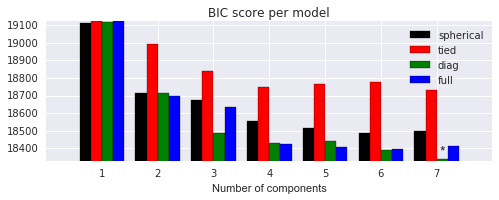

In [53]:
#Selecting the ebst model based on BIC:

best_gmm = get_bestModelByBIC()
print 'Best number of components:', best_gmm.n_components
print 'Best covariance type:', best_gmm.covariance_type

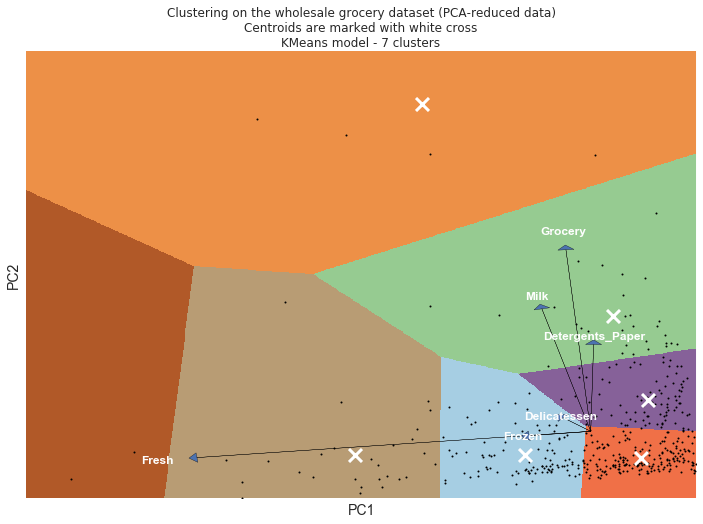

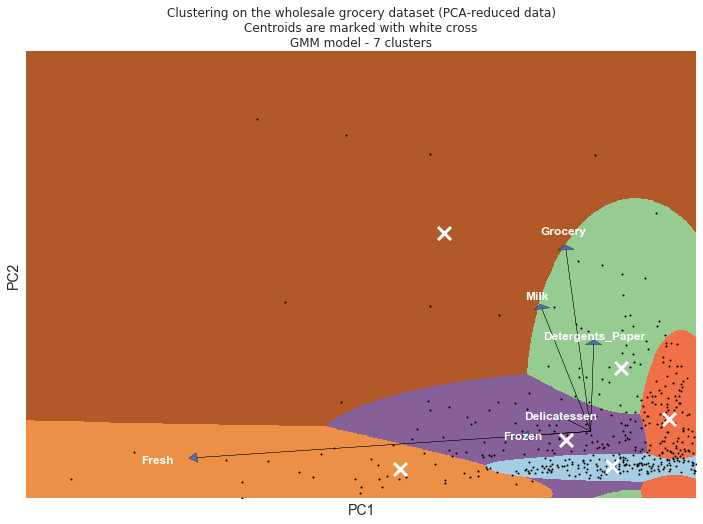

In [56]:
#KMeans is only for comparisson so it will use the same values as GMM
centroids = get_clusters('KMeans', best_gmm.n_components, best_gmm.covariance_type) 
centroids = get_clusters('GMM'    ,best_gmm.n_components, best_gmm.covariance_type)

**7)** What are the central objects in each cluster? Describe them as customers.

        The central objects in each cluster represent a typical customer in that segment of the market.
        For example, the bottom left cluster represents customers that buy mainly “Fresh” products as the top cluster correspond to users that buy  both “Fresh” and “Milk”. 
        The cluster shaped like an ellipsis (that starts at the word “milk” and ends at the right edge of the graph) represents customers who buy mainly 'grocery', 'milk' and some 'detergents_paper' (because they are on the positive side of PC2, and that’s what it represents), as the one on its right, it represents cutomers that buy even less "Fresh" products.
        The cluster that contais the origin seems to represent customers that buy a little of every product, but again some less "Fresh"
        The mostly horizontal cluster (besides the left cluster and below the cluster just described above) represents customers that may or may not buy Fresh products and don’t buy much from the 'grocery'\'milk' and 'detergents_paper' category.
        The most right cluster indicates customer that dont buy "Fresh" but some "Grocery", ""Milk" and "Detergents_paper".

### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

        Mainly clustering but I have to add PCA to the list because the clustering was done on top of the PCA output. 
        PCA was useful to reduce the number of dimensions from 6 to 2 without losing too much information and grouping the data into clusters enabled us to bucket customers into their respective market segments facilitating better business decision making.        

**9)** How would you use that technique to help the company design new experiments?

        All these techniques were used to categorize our clients' behaviours in terms of purchasing patterns. Knowing that is crucial to design any sort of experiment and avoid the initial problem our customer had. So, for example, we can consider each one of the clusters a different “market segment” and implement an A/B test inside that segment without worrying about affecting customers from other segments. If we go back to the initial problem, we can test the “morning delivery” change on each one of the clusters and apply it only to the customers who don’t seem to be affected by it (or not apply at all if two delivery schedules are not possible if the number of clusters affected is too high)

**10)** How would you use that data to help you predict future customer needs?

        I think it comes down to grouping (clustering) the customers into segments based on their purchasing behaviours. With that, maketing techniques can be applied (as discussed before) and we can analyse how profitable each group is; even find out that a particular group may not be profitable, for example.
        After the A/B tests, we’ll probably have identified which customers (clusters) prefer which method of delivery. We can use that output to label the customers and use that information on a “supervised learning problem”, for example, given a determined “purchasing pattern”, what is the best delivery time for this new customer?